In [312]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [313]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [314]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [315]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///Resources/hawaii.sqlite")

In [316]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [317]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [318]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [319]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [320]:
# Find the most recent date in the data set.
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


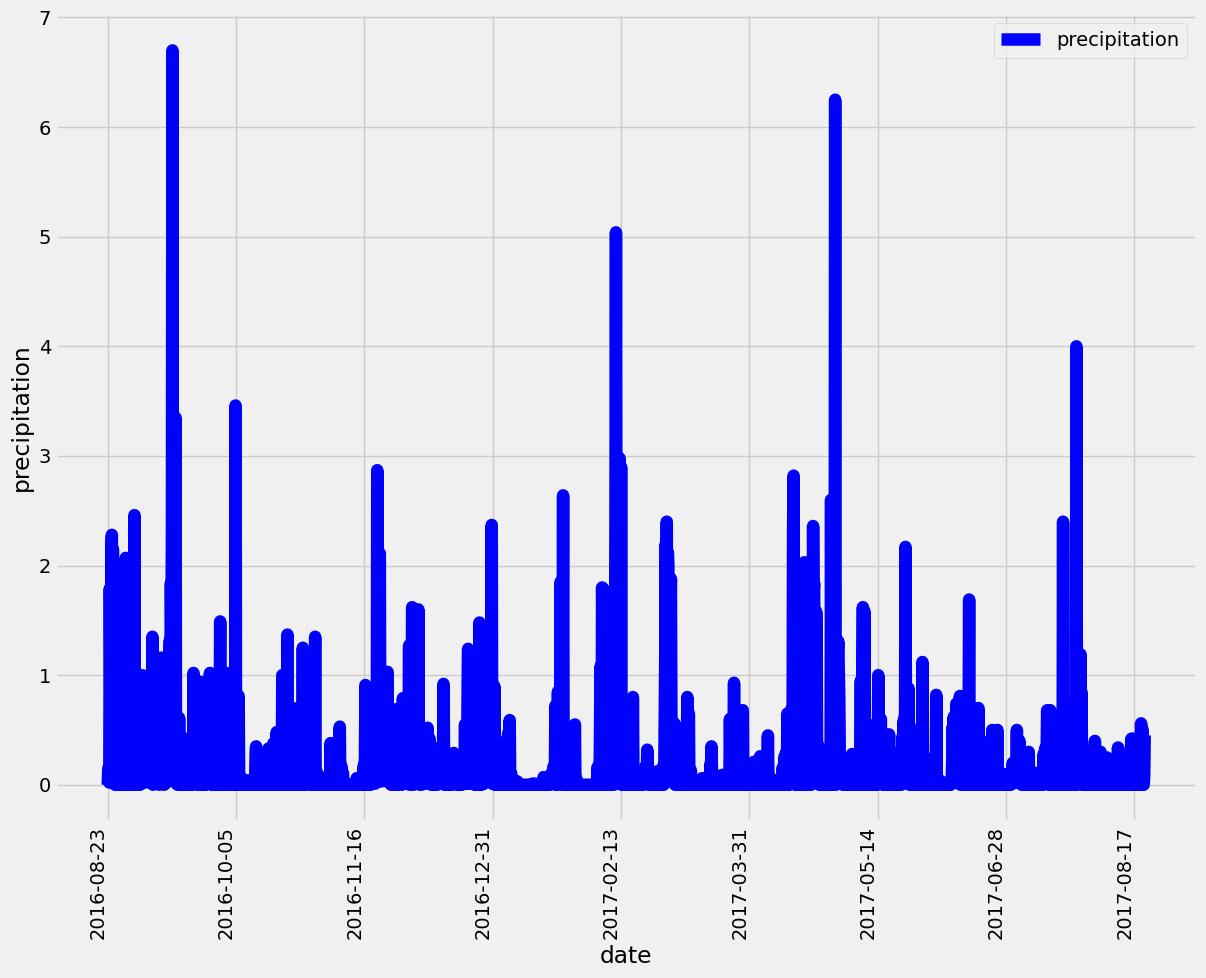

In [321]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")


# Calculate the date one year from the last date in data set.
year_back=latest_date-dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})


# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df_results.plot(x='date', y='precipitation',color='b', figsize=(12,10), legend=True, linewidth=9.0, grid=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.tight_layout()
plt.xlabel("date")
plt.ylabel("precipitation")
plt.show()


In [322]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [323]:
# Design a query to calculate the total number of stations in the dataset


In [324]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [325]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [326]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [327]:
# Close Session
session.close()